# Import dependencies

In [1]:

import numpy as np
import scipy
from typing import List
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient,\
    integrateVectorFunction, getIdxMax, calculateFirstDual, calculateSecondDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [2]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = True
    dt = 0.002
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    solver = computeSSNStep
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(96, 96),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

params = Parameters()

# Setup problem

In [3]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	raw_data = np.array([func.x.array for func in params.yd])
	timePoints = np.linspace(0, params.T, num=len(params.yd))
	integrated_raw_data = scipy.integrate.cumulative_simpson(raw_data, x=timePoints, axis=0, initial=0)
	second_integrated_raw_data = scipy.integrate.cumulative_simpson(integrated_raw_data, x=timePoints, axis=0, initial=0)
	params.yd_dual = [fem.Function(params.V) for _ in params.yd]
	params.yd_second_dual = [fem.Function(params.V) for _ in params.yd]
	for idx, (func1, func2) in enumerate(zip(params.yd_dual, params.yd_second_dual)):
		func1.x.array[:] = integrated_raw_data[idx]
		func2.x.array[:] = second_integrated_raw_data[idx]
	#if not params.useDummy:
	#	params.yd_dual_adjoint = solveAdjointEquation(params.yd_dual, params)
	#	params.yd_second_dual_adjoint = solveAdjointEquation(params.yd_second_dual, params)
	#else:
	#	params.yd_dual_adjoint = params.yd_dual
	#	params.yd_second_dual_adjoint = params.yd_second_dual


# Minimization algorithm

In [4]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params: Parameters):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	sizeActiveSet = np.empty(params.maxIterations)
	sizeActiveSet[:] = np.nan
	constraintViolation[:] = np.nan
	weights, slope, y_shift = params.solver(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
		#p_k = p_k - np.array([t**2 * p_k[-1,:] / params.T**2 for t in timePoints])
		#p_k_old = calculateFirstDual(active_set, weights, slope, y_shift, hesse, params)
		#P_k = -integrateVectorFunction(p_k, params)
		#P_k_old = calculateSecondDual(active_set, weights, slope, y_shift, hesse, params)
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params) - p_k * timePoints[:, np.newaxis]
		#P_k = P_k - np.array([t**2 * P_k[-1,:] / params.T**2 for t in timePoints])
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			print('Boundary values of duals: ', p_k[-1,:]/params.alpha, P_k[-1,:]/params.beta)
			_, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, p_k/params.alpha, marker='o', linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, P_k/params.beta, marker='o', linestyle='-', color='b', label='|P_k|/beta')
			ax2.grid(True), ax3.grid(True)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()

		idx_S = getIdxMax(p_k, active_set, type=0)
		idx_K = getIdxMax(P_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		#print(constraintViolation[k])
		sizeActiveSet[k] = len(active_set)
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:# or abs(idx_S * params.dt - params.T/2) > params.T/2 - params.beta/params.alpha:
			active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
		else:
			active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)

		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = params.solver(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		if params.verbose:
			print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))

	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
	plot_array(discreteDf, params.T, label='grad', ax=ax1)
	ax2.plot(timePoints, np.linalg.norm(p_k, axis=1)/params.alpha, marker='o', linestyle='-', color='b', label='|p_k|/alpha')
	ax3.plot(timePoints, np.linalg.norm(P_k, axis=1)/params.beta, marker='o', linestyle='-', color='b', label='|P_k|/beta')
	plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
	mpl.pyplot.show()
	printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
	showNonStationarity(discreteDf, active_set, params)
	return active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet


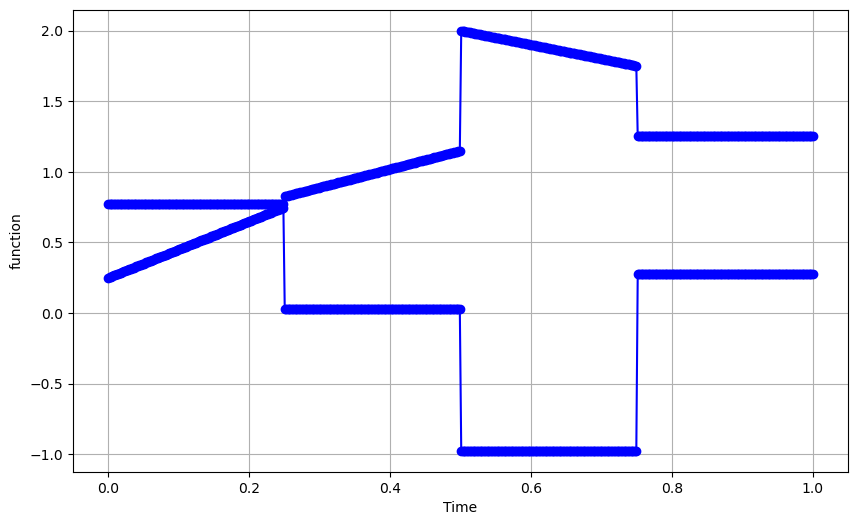

Test for alpha= 7e-09 , beta= 1e-09
Objective upper bound:  0.038356384039723586
weights:  [] slope:  [ 1.212692   -0.93544064] y_shift [0.546744   0.49221517]
Objective:  0.006480077465339715
0 : Active set:
slope:  [ 1.212692   -0.93544064] y_shift [0.546744   0.49221517]
0 : Hesse condition: 19.281470067903964
First conditions:  [-2.16490844e-13  1.91351147e-12  4.44774951e-13  4.71770396e-13]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)
Boundary values of duals:  [6.35392787e-05 6.73957708e-05] [-0.00066127  0.00144174]


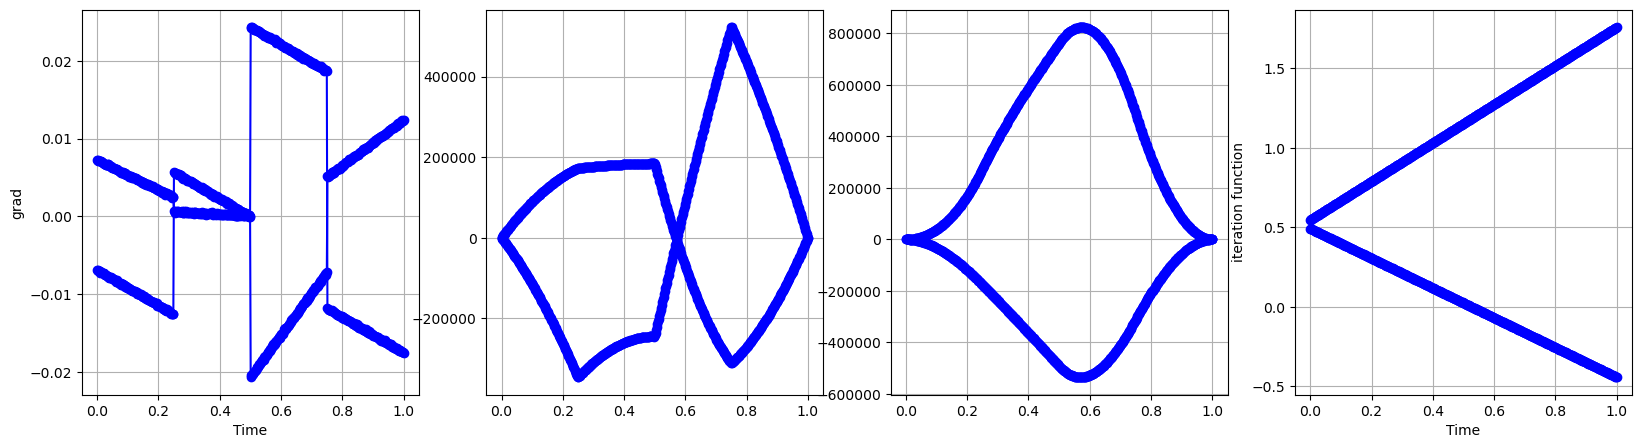

|p_max|/alpha:  607862.6361840626 , |P_max|/beta:  981772.621039162
x_S:  0.75 x_K:  0.5700000000000001 
New point: sigma= [-0.54486814  0.83852174] x_0 = 0.5700000000000001 , type = 1
weights:  [8.19962179] slope:  [ 2.9805041  -3.65600509] y_shift [0.0758789  1.21685036]
Objective:  0.002455175558158977
1 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 8.199621791991538 	id: 140075355461520
slope:  [ 2.9805041  -3.65600509] y_shift [0.0758789  1.21685036]
1 : Hesse condition: 307.06992686532584
First conditions:  [-1.76676049e-12  2.71894445e-12  4.72087809e-13 -7.26569060e-13]  (should be close to 0)
Second conditions:  [1.]  (should be greater or equal than 0)
Boundary values of duals:  [ 6.74411155e-05 -1.03795580e-04] [-0.00223885  0.00344551]


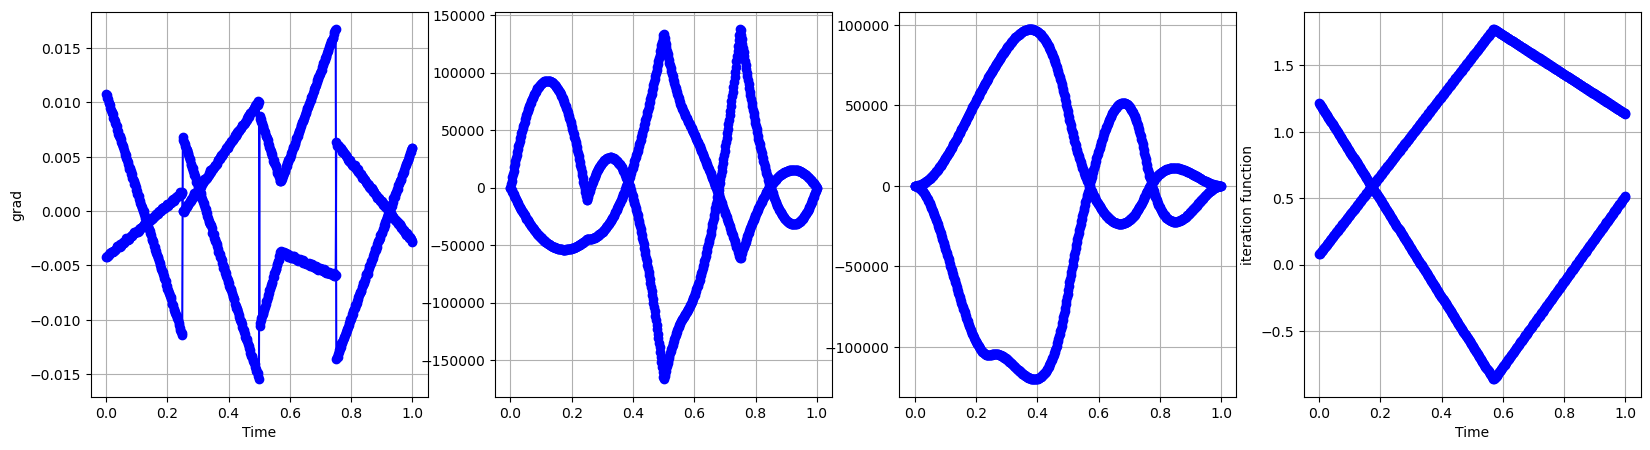

|p_max|/alpha:  213531.5623841091 , |P_max|/beta:  154246.94854137013
x_S:  0.5 x_K:  0.384 
New point: sigma= [ 0.62528014 -0.78040038] x_0 = 0.5 , type = 0
weights:  [7.53681063 1.02006657] slope:  [ 1.88086182 -2.2419979 ] y_shift [0.27361149 0.95899317]
Objective:  0.0016882362892378067
2 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 7.536810625761065 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.0200665721237312 	id: 140075355857568
slope:  [ 1.88086182 -2.2419979 ] y_shift [0.27361149 0.95899317]
2 : Hesse condition: 446.1474241759008
First conditions:  [ 1.09392168e-12 -1.40687208e-12 -2.05363694e-13  2.67335413e-13]  (should be close to 0)
Second conditions:  [1.         0.99999999]  (should be greater or equal than 0)
Boundary values of duals:  [-2.93376705e-05  3.81907732e-05] [ 0.00129929 -0.00167421]


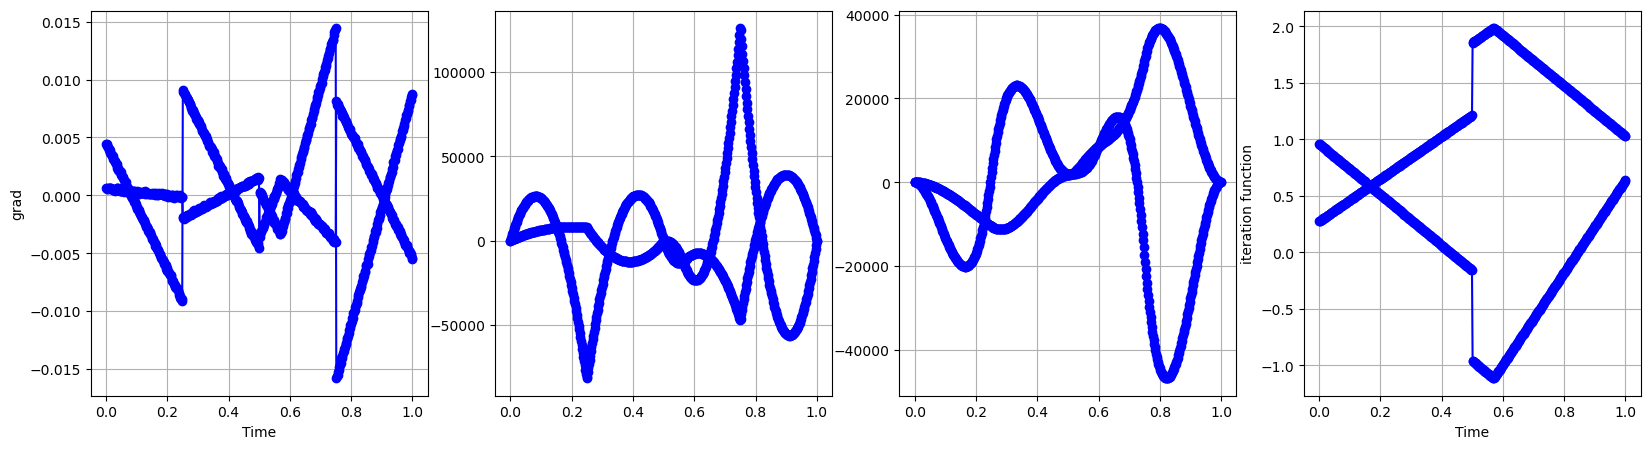

|p_max|/alpha:  134429.68827175064 , |P_max|/beta:  58947.394231290324
x_S:  0.748 x_K:  0.8140000000000001 
New point: sigma= [-0.35038734  0.93660488] x_0 = 0.748 , type = 0
weights:  [3.76046289 0.93136417 1.2025233 ] slope:  [ 1.62538218 -2.36389225] y_shift [0.3446679 0.995211 ]
Objective:  0.0011284327699436316
3 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 3.760462891856983 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 0.9313641745628711 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.2025232993778376 	id: 140075357327856
slope:  [ 1.62538218 -2.36389225] y_shift [0.3446679 0.995211 ]
3 : Hesse condition: 979.7283621660383
First conditions:  [ 2.57357781e-13  1.16877000e-13 -6.89257168e-14 -4.19880839e-14]  (should be close to 0)
Second conditions:  [1.         0.99999999 0.99999999]  (should be greater or equal than 0)
Boundary values of

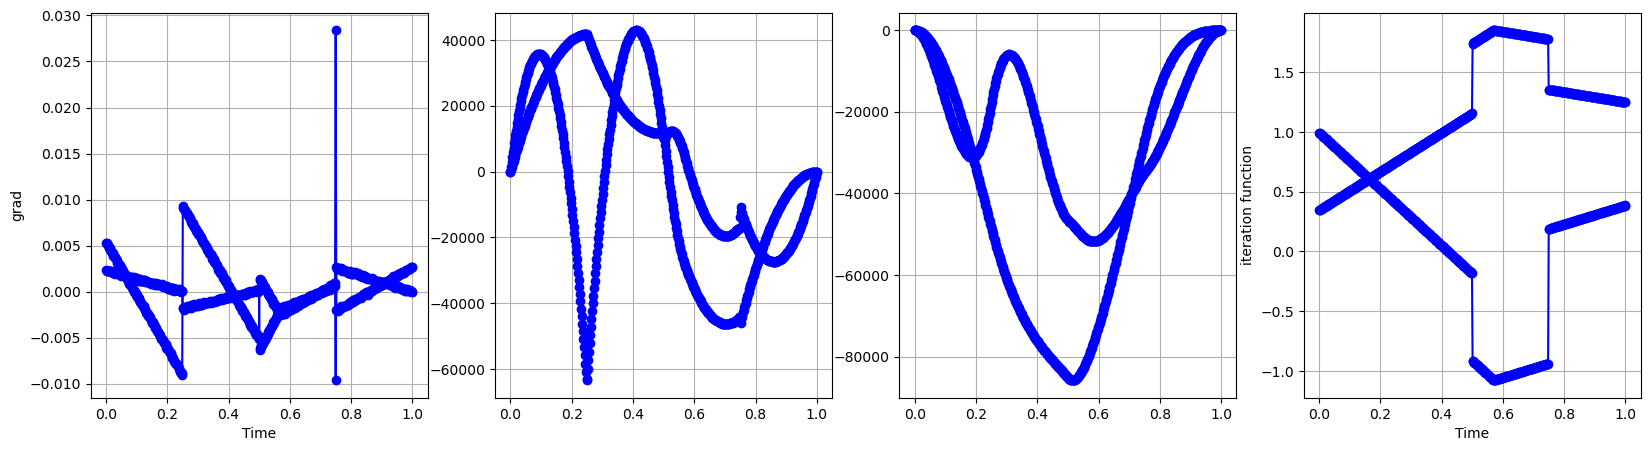

|p_max|/alpha:  75971.53934970581 , |P_max|/beta:  98314.51785315486
x_S:  0.248 x_K:  0.524 
New point: sigma= [-0.86973029 -0.49352733] x_0 = 0.524 , type = 1
weights:  [3.42011502 0.92436001 1.29457167 0.84375412] slope:  [ 1.93549212 -2.16322985] y_shift [0.26589291 0.94405382]
Objective:  0.0010869554870614005
4 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 3.4201150240703346 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 0.924360005710004 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.2945716730626202 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 0.8437541164925975 	id: 140075357459264
slope:  [ 1.93549212 -2.16322985] y_shift [0.26589291 0.94405382]
4 : Hesse condition: 1071.596195163053
First conditions:  [-3.08085044e-13 -1.99512233e-13  8.11707315e-14  5.24933533e-14]  (should be close to 0)

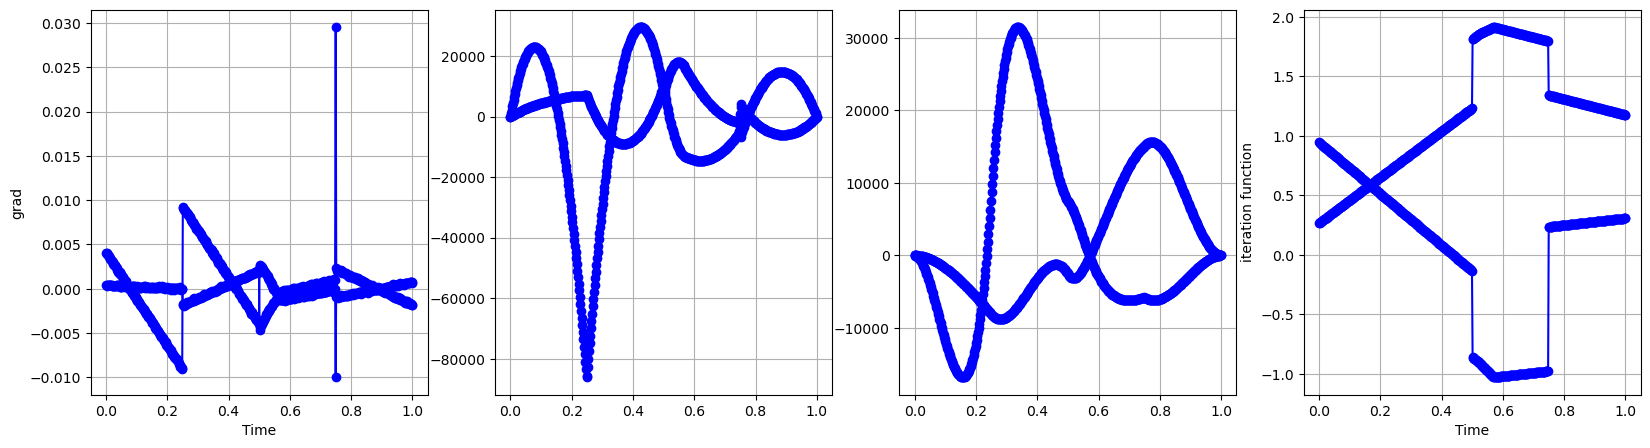

|p_max|/alpha:  86376.28222841858 , |P_max|/beta:  32271.378912081367
x_S:  0.248 x_K:  0.332 
New point: sigma= [ 0.08150585 -0.99667286] x_0 = 0.248 , type = 0
weights:  [1.2996782  1.17563651 1.32195673 1.86083953 0.72173816] slope:  [ 1.59816331 -0.15701357] y_shift [0.30761406 0.79479593]
Objective:  0.0008709194203154088
5 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.299678200606384 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.175636512260893 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.3219567264667746 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.860839529421093 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.721738158026769 	id: 140075355847184
slope:  [ 1.59816331 -0.15701357] y_shift [0.30761406 0.79479593]
5 : Hesse condition: 2552.6

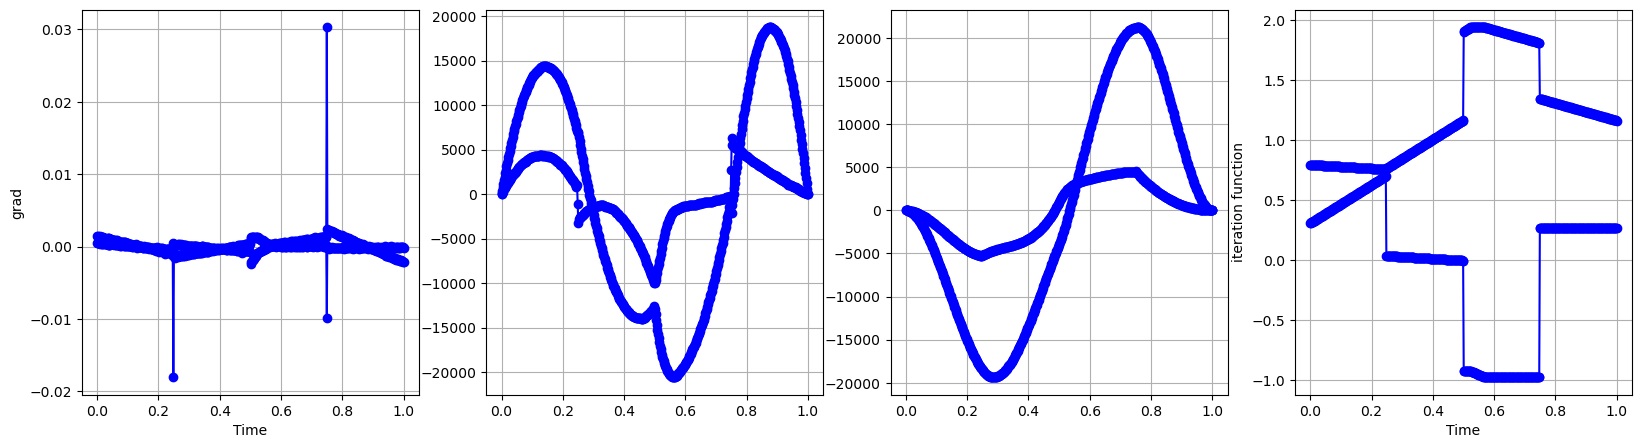

|p_max|/alpha:  20653.240041421595 , |P_max|/beta:  21672.188026073276
x_S:  0.562 x_K:  0.752 
New point: sigma= [0.97958778 0.20101689] x_0 = 0.752 , type = 1
weights:  [1.48939157 1.20371989 1.30981647 2.44379093 0.7375523  1.19006474] slope:  [ 1.66221417 -0.05996376] y_shift [0.29592162 0.78246301]
Objective:  0.0008580255778830089
6 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.4893915713034727 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.203719890429676 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.309816467522455 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 2.4437909348003446 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.7375522992765403 	id: 140075355847184
	 5 sigma= [0.97958778 0.20101689] ,	x_0 = 0.752 ,	type = 1 	weight: 1.1900647442

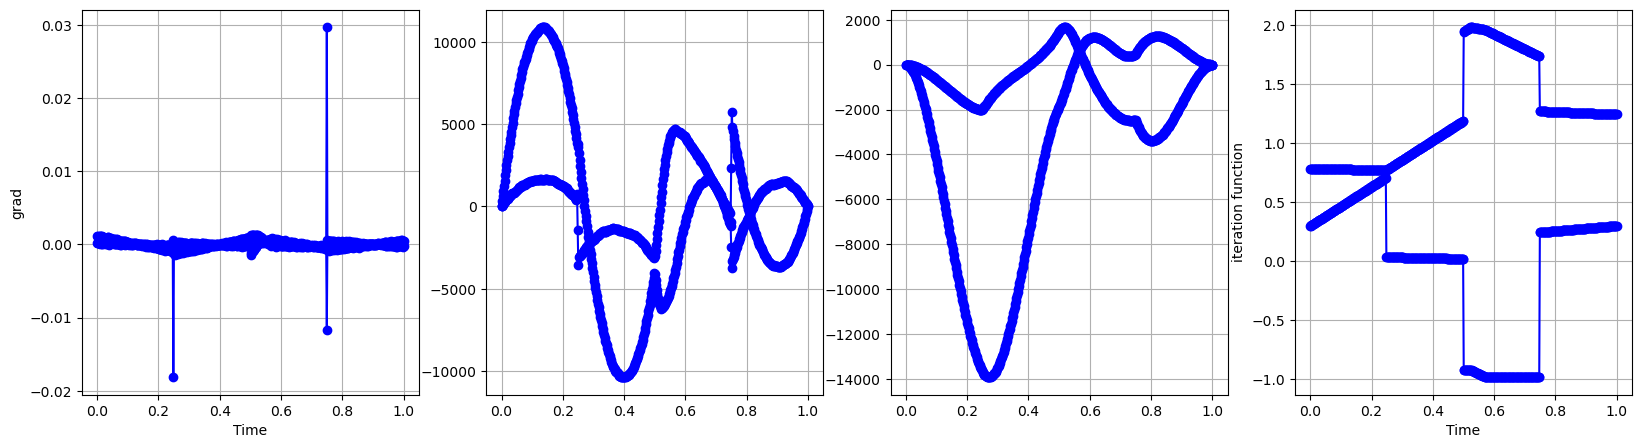

|p_max|/alpha:  11016.998203240943 , |P_max|/beta:  14023.166362901035
x_S:  0.136 x_K:  0.268 
New point: sigma= [-0.99329466 -0.11561019] x_0 = 0.268 , type = 1
weights:  [1.27455629 1.2379664  1.30862318 2.05109982 0.74990319 1.01652539
 0.67520604] slope:  [ 1.33118342 -0.03193765] y_shift [0.42967455 0.78991858]
Objective:  0.0008532912281668939
7 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.2745562932725143 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2379664019009229 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.3086231820267686 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 2.05109982455589 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.7499031920077712 	id: 140075355847184
	 5 sigma= [0.97958778 0.20101689] ,	x_0 = 0.752 ,	type = 1 	weight

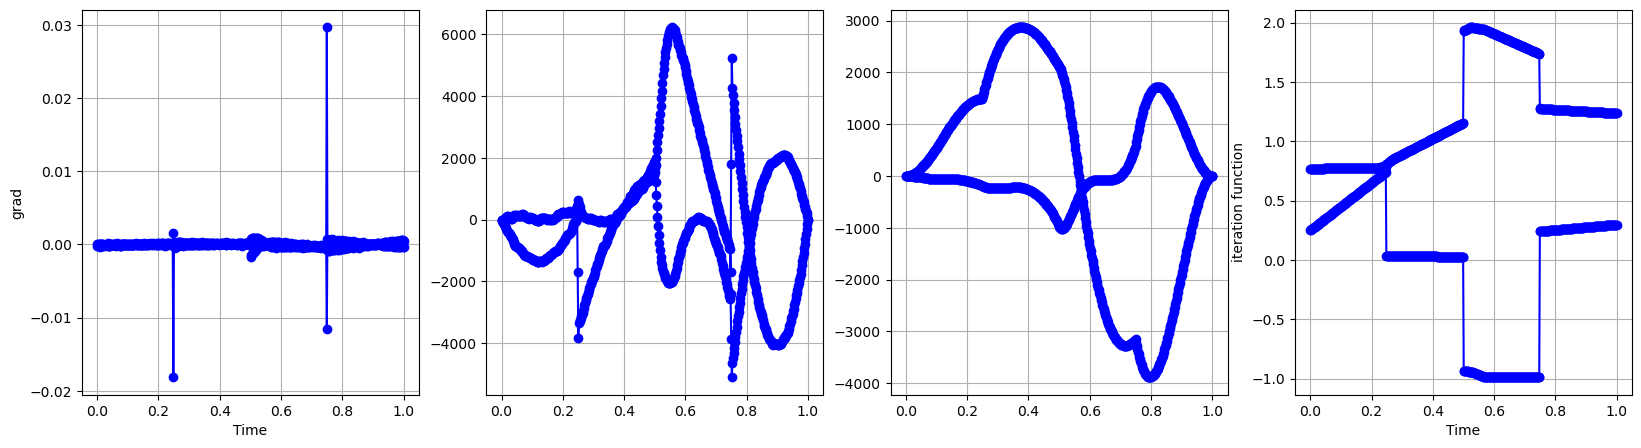

|p_max|/alpha:  7293.606911093298 , |P_max|/beta:  4210.369658159493
x_S:  0.75 x_K:  0.8 
New point: sigma= [-0.69891545  0.71520431] x_0 = 0.75 , type = 0
weights:  [1.17910545 1.23483382 1.0359553  1.64706785 0.7456188  1.0467714
 0.76660276 0.30811118] slope:  [ 1.26458292 -0.06364357] y_shift [0.45175123 0.79543063]
Objective:  0.0008459853719555953
8 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.179105450735161 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2348338151952871 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 1.035955299120979 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.6470678464365673 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.7456187978362274 	id: 140075355847184
	 5 sigma= [0.97958778 0.20101689] ,	x_0 = 0.752 ,	type = 1 	we

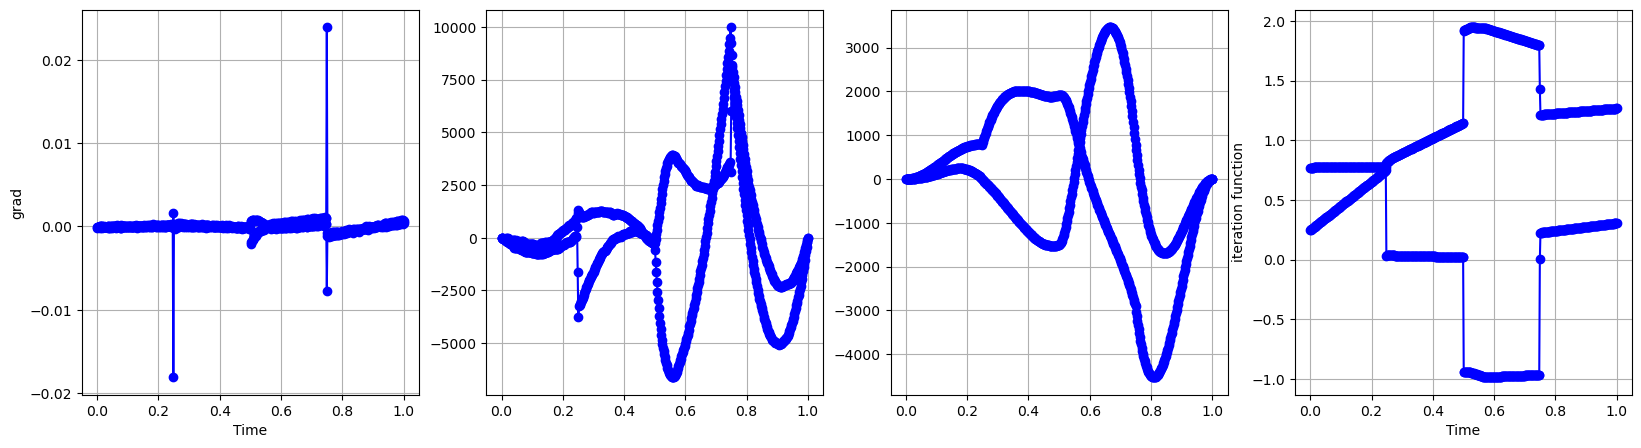

|p_max|/alpha:  11203.54851949518 , |P_max|/beta:  4760.264692400102
x_S:  0.752 x_K:  0.8140000000000001 
New point: sigma= [0.72312924 0.69071275] x_0 = 0.752 , type = 0
weights:  [1.13099727 1.23155779 0.32225694 1.8965096  0.74990346 0.94972914
 0.70919832 0.95302128 0.37238008] slope:  [ 1.30631024 -0.03691034] y_shift [0.43792205 0.79112557]
Objective:  0.0008311880326289953
9 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.1309972668419808 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2315577875762198 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.3222569413385631 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.8965096049375672 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.7499034612694659 	id: 140075355847184
	 5 sigma= [0.97958778 0.20101689]

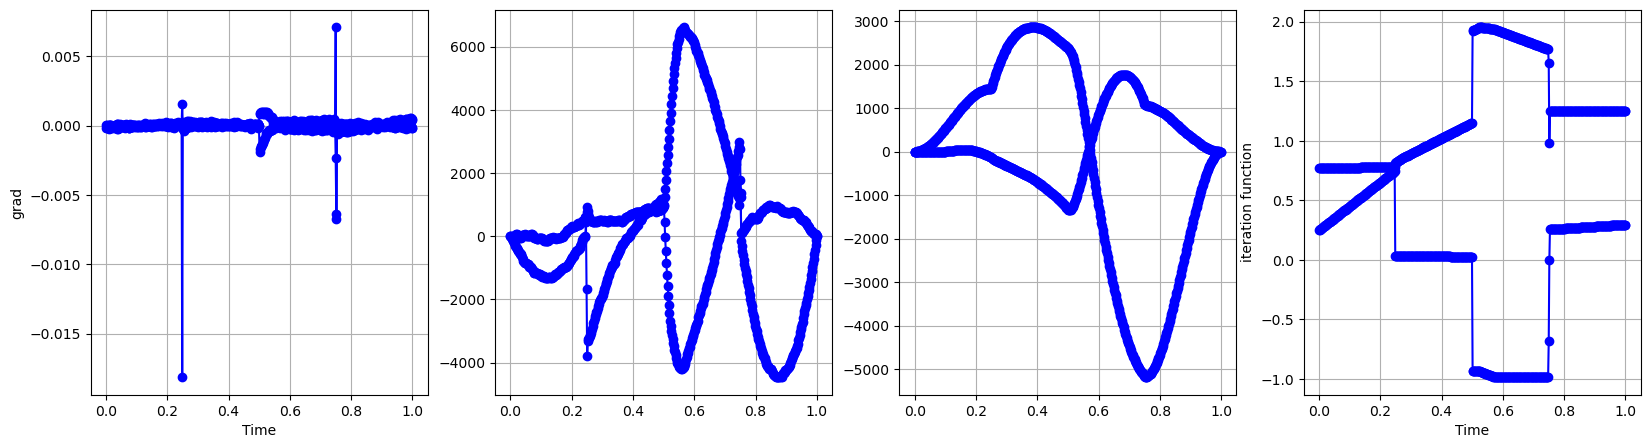

|p_max|/alpha:  7810.472764227557 , |P_max|/beta:  5292.633862838149
x_S:  0.5640000000000001 x_K:  0.75 
New point: sigma= [-0.53196341  0.84676734] x_0 = 0.5640000000000001 , type = 0
weights:  [1.04200246 1.2609276  0.31911455 1.85797427 0.74099267 0.88727257
 0.71077228 0.9673471  0.37762184 0.0585799 ] slope:  [ 1.30573401 -0.07527013] y_shift [0.43809861 0.79589527]
Objective:  0.0008295835244783857
10 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.0420024632019982 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2609275958370798 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.31911455068398725 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.8579742674372157 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.7409926717640054 	id: 140075355847184
	 5 sig

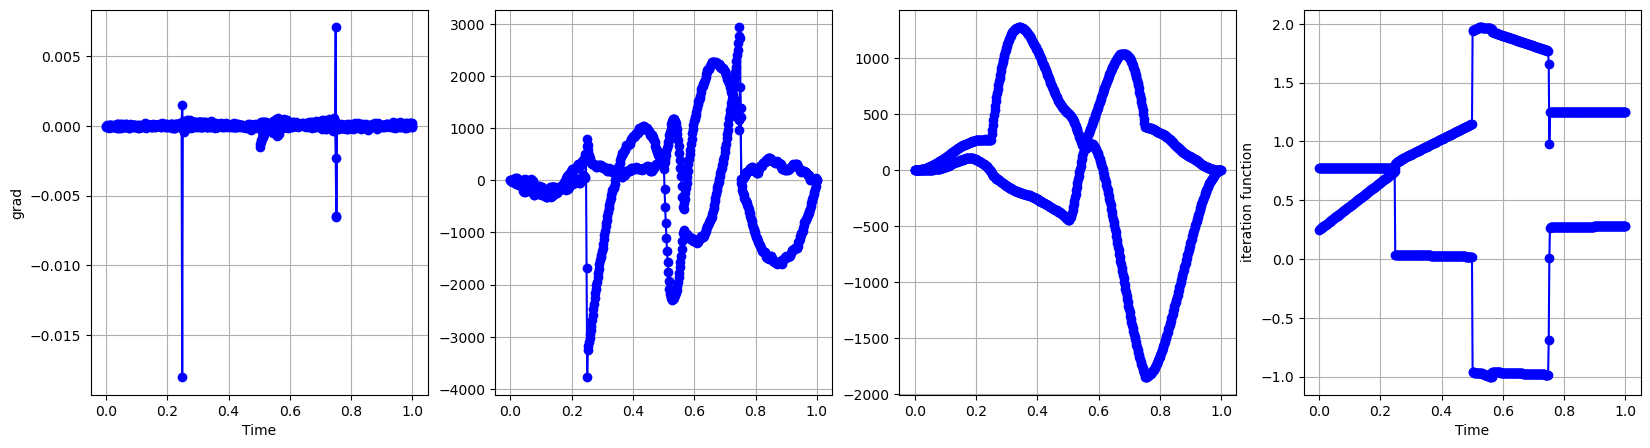

|p_max|/alpha:  3859.6597412843967 , |P_max|/beta:  1887.621025337121
x_S:  0.25 x_K:  0.75 
New point: sigma= [ 0.20694144 -0.97835333] x_0 = 0.25 , type = 0
weights:  [0.92861611 1.27261851 0.31782658 1.72006215 0.20539162 0.8492901
 0.60433518 0.96950945 0.37535189 0.05626912 0.55408672] slope:  [ 1.1604317  -0.03649544] y_shift [0.43202136 0.7885939 ]
Objective:  0.0008228069539368323
11 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9286161134216042 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2726185107795664 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.3178265752071441 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.7200621466128145 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.20539162087151752 	id: 140075355847184
	 5 sigma= [0.97958778 0

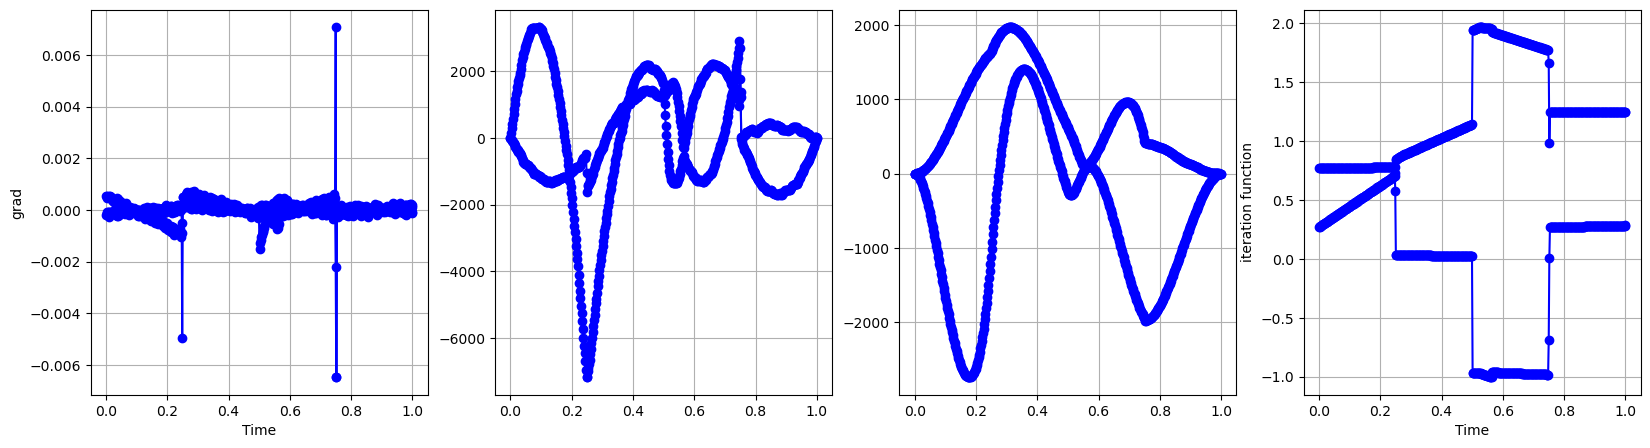

|p_max|/alpha:  7142.585442996426 , |P_max|/beta:  2991.8337351396704
x_S:  0.252 x_K:  0.184 
New point: sigma= [-0.97934961 -0.20217402] x_0 = 0.252 , type = 0
weights:  [0.99427643 1.2646664  0.31921521 1.87220269 0.02431091 0.89027313
 0.68595034 0.96718123 0.37780401 0.05663855 0.72805599 0.08417341] slope:  [ 1.28923532 -0.02920152] y_shift [0.43518694 0.78965848]
Objective:  0.00082068759428206
12 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9942764327015999 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2646663993885696 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.3192152107820699 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.8722026910813978 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.02431090532492927 	id: 140075355847184
	 5 sigma= 

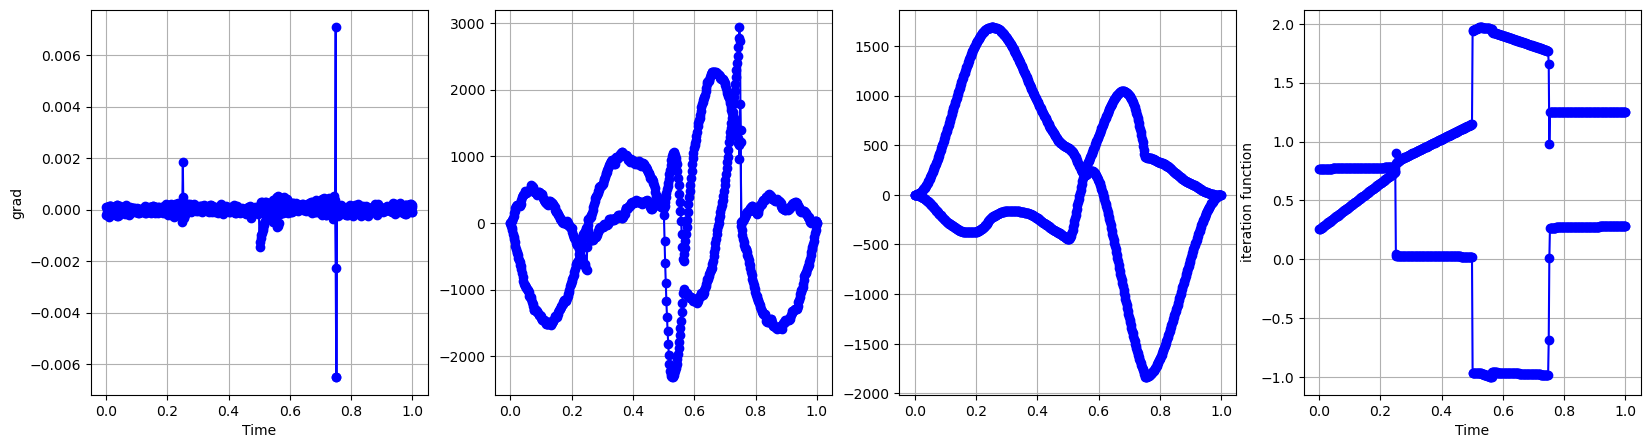

|p_max|/alpha:  3089.557382301564 , |P_max|/beta:  1875.7995794981146
x_S:  0.746 x_K:  0.75 
New point: sigma= [0.95084769 0.30965896] x_0 = 0.746 , type = 0
weights:  [1.02351151 1.26467098 0.24054392 1.9668671  0.02499023 0.97247815
 0.66752214 1.10473575 0.27279805 0.05535851 0.7282746  0.08554477
 0.16655804] slope:  [ 1.30677362 -0.02158987] y_shift [0.43037685 0.78840837]
Objective:  0.0008189247208228358
13 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 1.0235115054772543 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2646709803370713 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.24054392088144338 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9668671027765052 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.024990227698906832 	id: 14007535584718

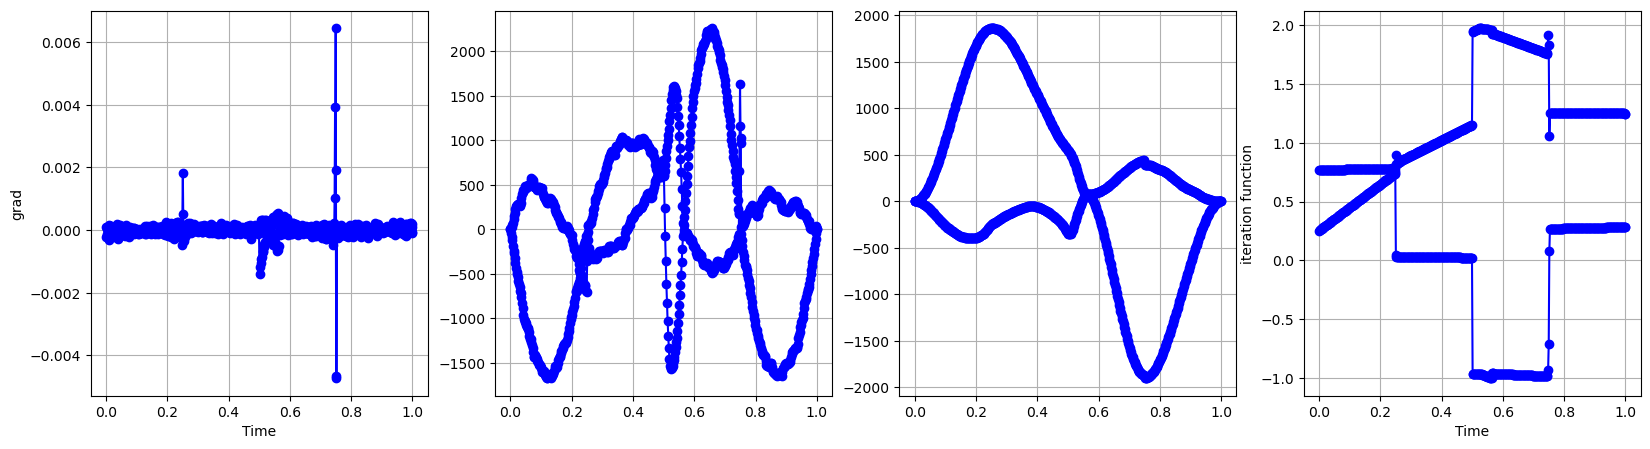

|p_max|/alpha:  2312.3059638402083 , |P_max|/beta:  1944.1953743611152
x_S:  0.656 x_K:  0.75 
New point: sigma= [-0.21086927  0.97751427] x_0 = 0.656 , type = 0
weights:  [0.98356187 1.26467845 0.23536571 1.98735522 0.02495539 0.97756362
 0.66832934 1.10939612 0.27576171 0.05009072 0.72826032 0.08548535
 0.16632735 0.01829189] slope:  [ 1.30600998 -0.02196407] y_shift [0.43058697 0.78846818]
Objective:  0.0008187763977307252
14 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9835618699615036 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.264678449858073 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23536570740612528 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.987355216708962 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.024955390224079957 	id: 14

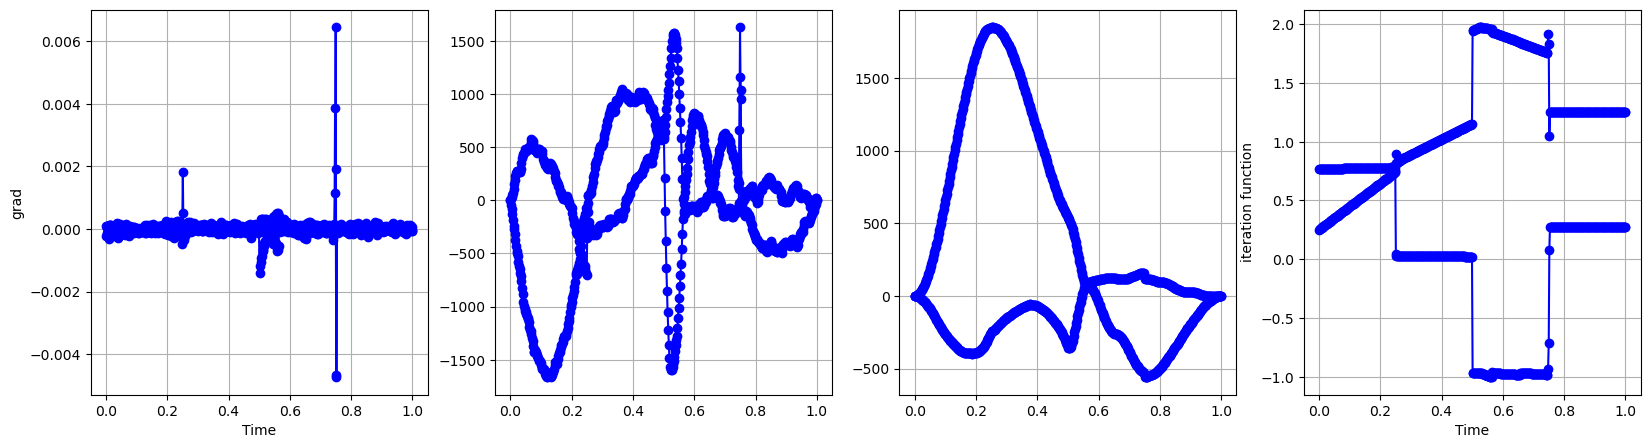

|p_max|/alpha:  2201.5534065192646 , |P_max|/beta:  1865.747516867194
x_S:  0.53 x_K:  0.25 
New point: sigma= [-0.70094781  0.71321257] x_0 = 0.53 , type = 0
weights:  [0.98736848 1.28415866 0.23543029 1.97244969 0.02444512 0.94976829
 0.65272784 1.10918011 0.2755191  0.03362106 0.72745117 0.08680445
 0.16417444 0.01840181 0.03929978] slope:  [ 1.3218355  -0.02423226] y_shift [0.42639315 0.78848936]
Objective:  0.0008184732976314834
15 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9873684792564229 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2841586636180118 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23543029281787456 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9724496912158538 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.0244451198417188

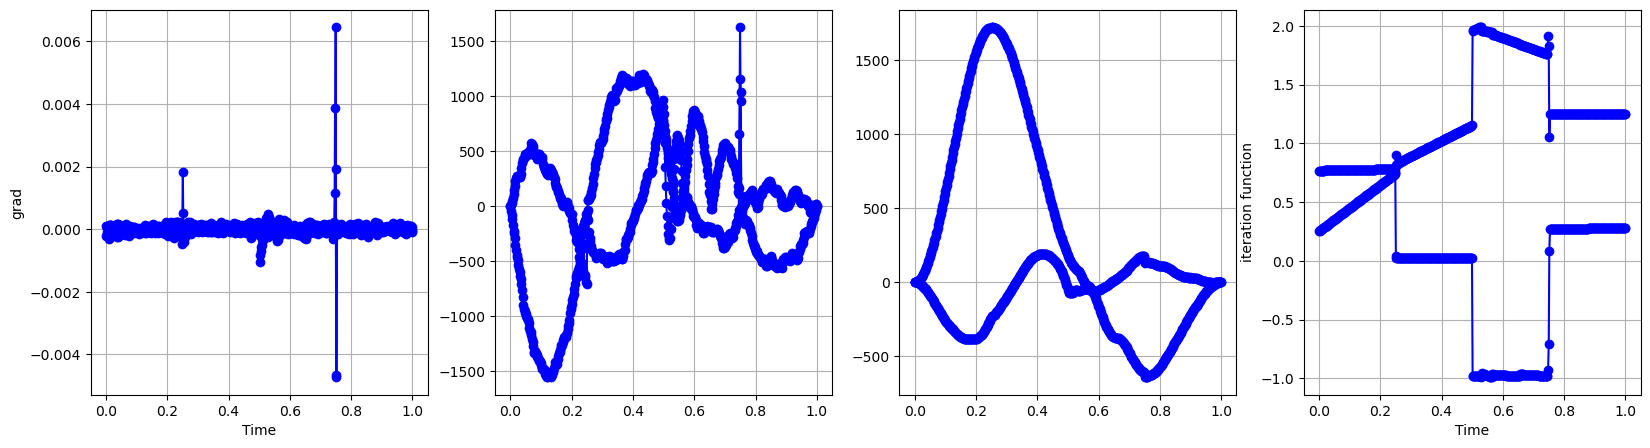

|p_max|/alpha:  1591.1770021299187 , |P_max|/beta:  1739.5071778594552
x_S:  0.132 x_K:  0.25 
New point: sigma= [-0.13315151  0.99109569] x_0 = 0.25 , type = 1
weights:  [0.94275242 1.29082778 0.23540481 1.99267328 0.0175138  0.96112305
 0.66336983 1.10926866 0.27561843 0.03175731 0.73331694 0.08665232
 0.16504654 0.01834425 0.03846402 0.10194513] slope:  [1.30420177 0.0197746 ] y_shift [0.43180885 0.77047382]
Objective:  0.0008183846461105931
16 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9427524195322865 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2908277781889417 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23540480886846066 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.992673280035251 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.017513

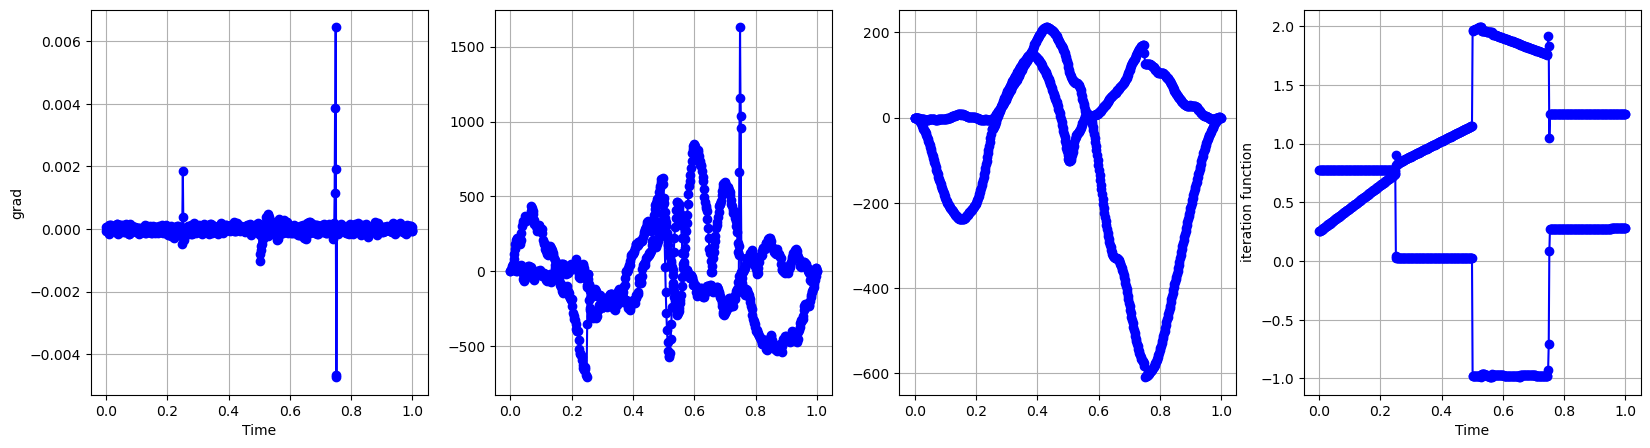

|p_max|/alpha:  852.5947676769963 , |P_max|/beta:  621.6646074408353
x_S:  0.598 x_K:  0.75 
New point: sigma= [-0.10338945  0.99464095] x_0 = 0.598 , type = 0
weights:  [0.94069177 1.29090447 0.23571398 2.01129958 0.01751411 0.97974772
 0.66509109 1.11012981 0.27626337 0.02510337 0.73321125 0.08651858
 0.16633262 0.01486697 0.03877363 0.10072314 0.01122808] slope:  [1.30266677 0.01836616] y_shift [0.43222487 0.77082972]
Objective:  0.0008183511508073131
17 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9406917741201081 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.290904471163167 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2357139770930777 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 2.0112995848816473 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight:

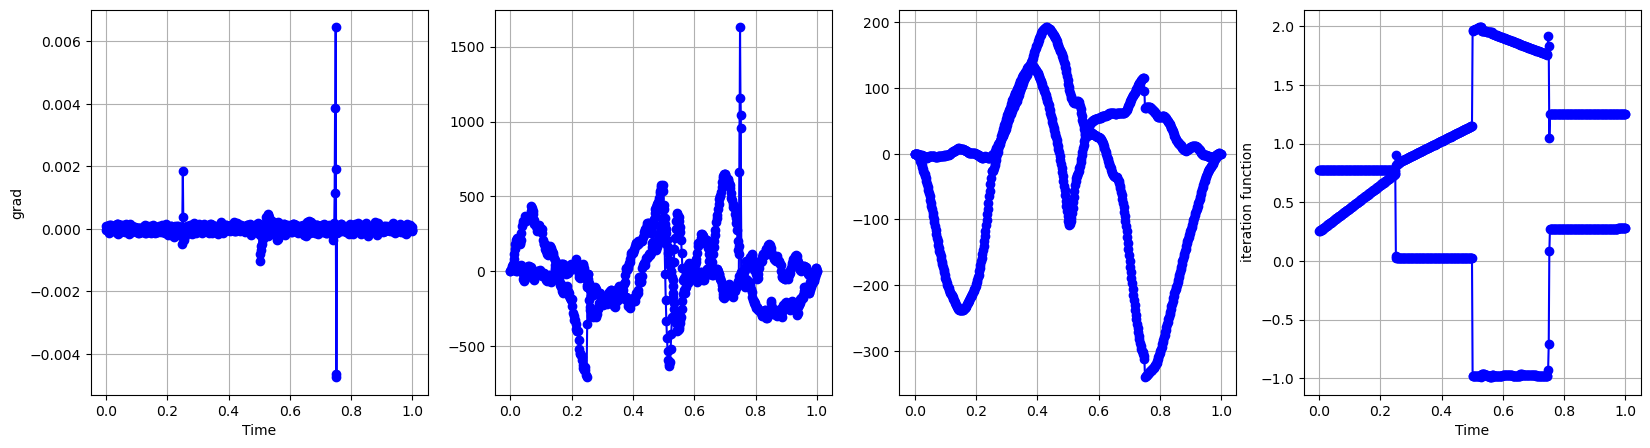

|p_max|/alpha:  722.0643796831105 , |P_max|/beta:  347.25966521485856
x_S:  0.498 x_K:  0.75 
New point: sigma= [0.796866   0.60415608] x_0 = 0.498 , type = 0
weights:  [0.94778213 1.29111028 0.23566678 2.00149559 0.01751805 0.99396433
 0.68541561 1.11020916 0.27636652 0.02441207 0.73221742 0.08499066
 0.16742924 0.01493609 0.03970597 0.08821809 0.01078651 0.0066995 ] slope:  [1.2842831  0.00364176] y_shift [0.43720155 0.77455549]
Objective:  0.0008183347812697868
18 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9477821306997589 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2911102807142583 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2356667780022397 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 2.001495588169587 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 

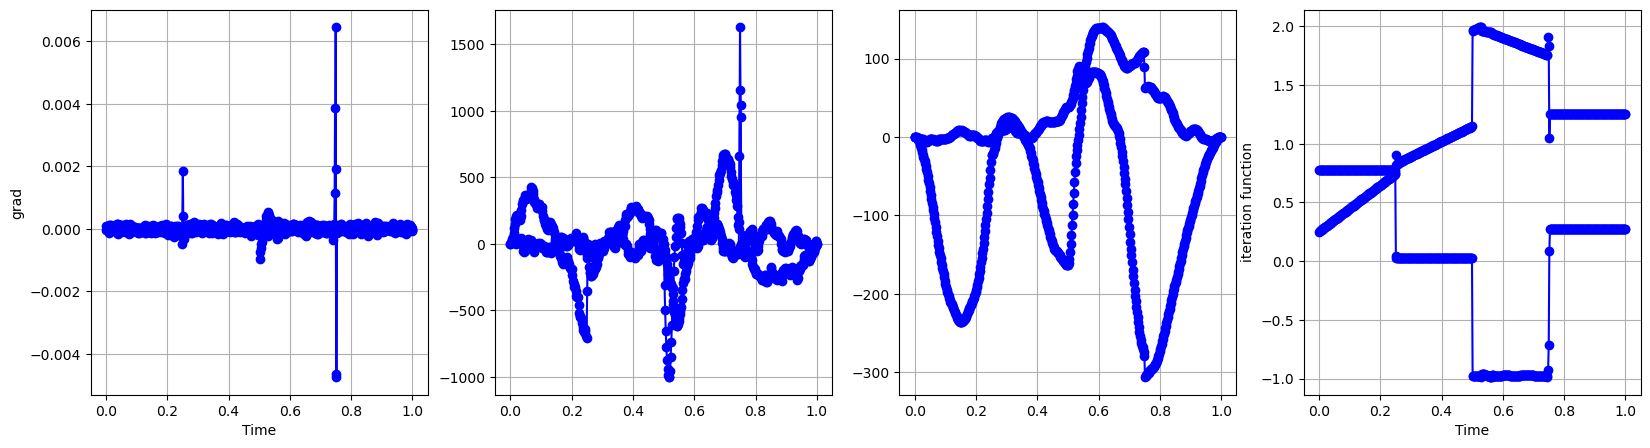

|p_max|/alpha:  1036.069496138705 , |P_max|/beta:  312.67191580228484
x_S:  0.516 x_K:  0.75 
New point: sigma= [-0.96801167 -0.25090517] x_0 = 0.516 , type = 0
weights:  [0.940279   1.29427901 0.23576067 1.97836206 0.01751704 0.96564154
 0.68191903 1.11005057 0.27616068 0.02593916 0.73247223 0.08537913
 0.16524356 0.01479828 0.03275429 0.09056922 0.01166671 0.02215905
 0.0233525 ] slope:  [1.28740775 0.00637136] y_shift [0.43635346 0.77386521]
Objective:  0.0008182498582908275
19 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9402790025742377 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2942790081978859 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23576066700655174 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9783620577660381 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 =

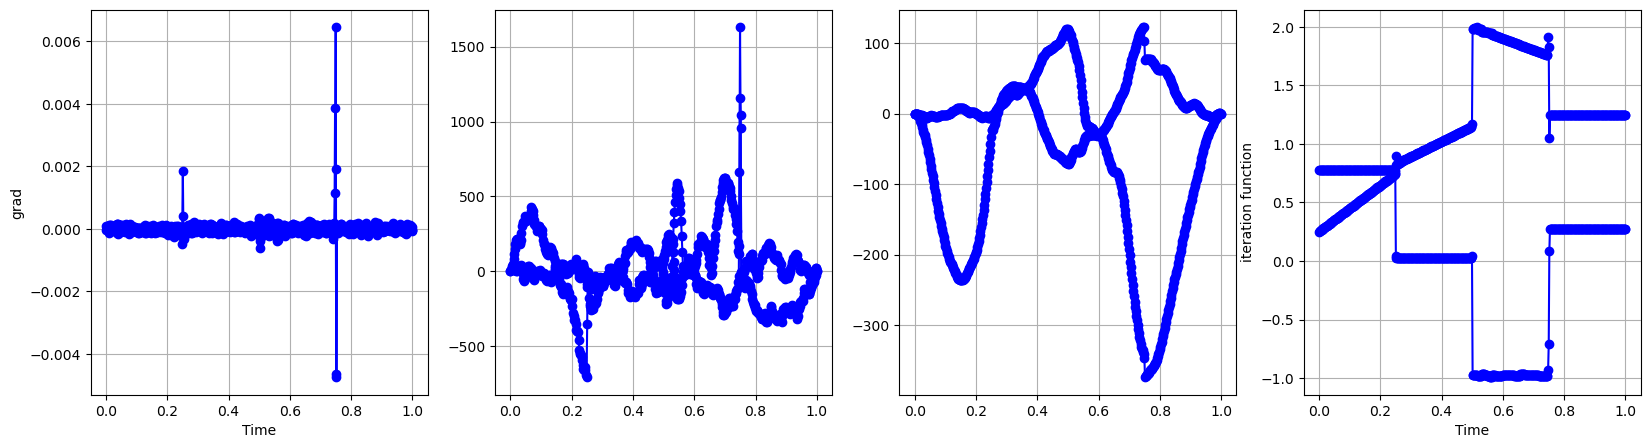

|p_max|/alpha:  695.5629763955044 , |P_max|/beta:  381.73292146190374
x_S:  0.246 x_K:  0.75 
New point: sigma= [-0.99778602 -0.06650606] x_0 = 0.246 , type = 0
weights:  [0.94014979 1.29429301 0.23576067 1.97817274 0.01078415 0.9656419
 0.70205153 1.11005058 0.27616068 0.02593622 0.74321465 0.05719893
 0.16524359 0.01479828 0.03275054 0.09141027 0.01166664 0.02217369
 0.02334967 0.03298905] slope:  [1.28717235 0.00638615] y_shift [0.4400962  0.77415518]
Objective:  0.0008181714361346366
20 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9401497855924873 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2942930115330875 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23576066696022768 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9781727353328524 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.9966728

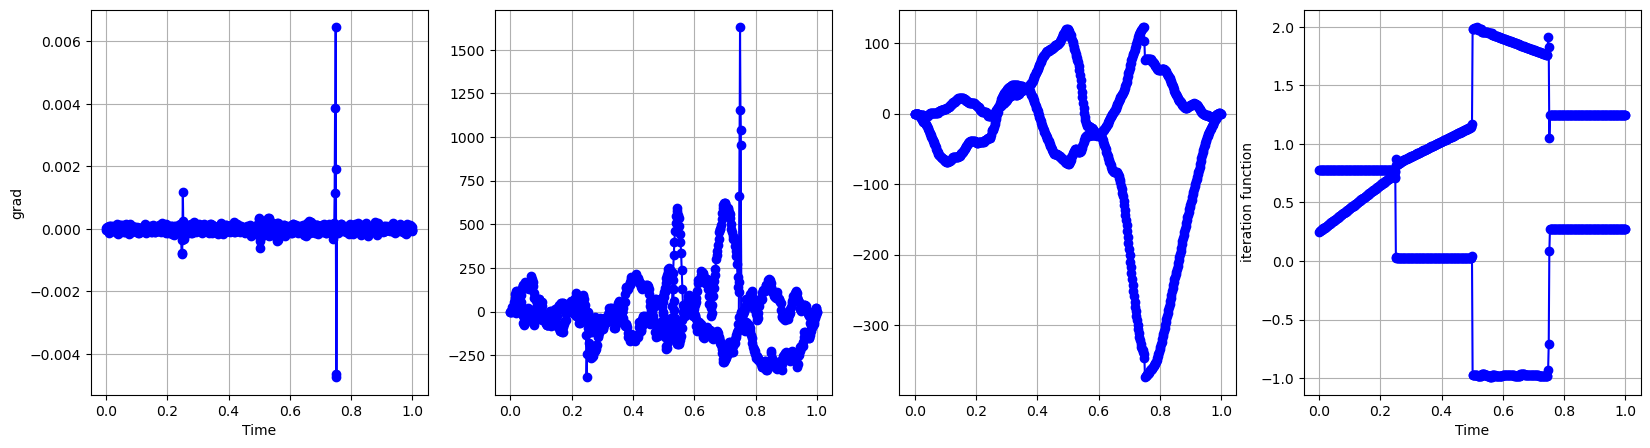

|p_max|/alpha:  685.1419654748441 , |P_max|/beta:  381.7311413531724
x_S:  0.6960000000000001 x_K:  0.75 
New point: sigma= [-0.42439475  0.90547728] x_0 = 0.6960000000000001 , type = 0
weights:  [0.930564   1.29438922 0.2321878  1.97117547 0.01078415 0.95539162
 0.70205438 1.11085431 0.27656196 0.02626715 0.74321013 0.05719832
 0.16524555 0.01038134 0.03277378 0.09137357 0.01172626 0.02213832
 0.02377127 0.03298903 0.00902588] slope:  [1.28717441 0.00634944] y_shift [0.44009574 0.77416436]
Objective:  0.0008181498837886047
21 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9305639987077103 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2943892162555348 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23218780244895118 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9711754675532496 	id: 1400753574592

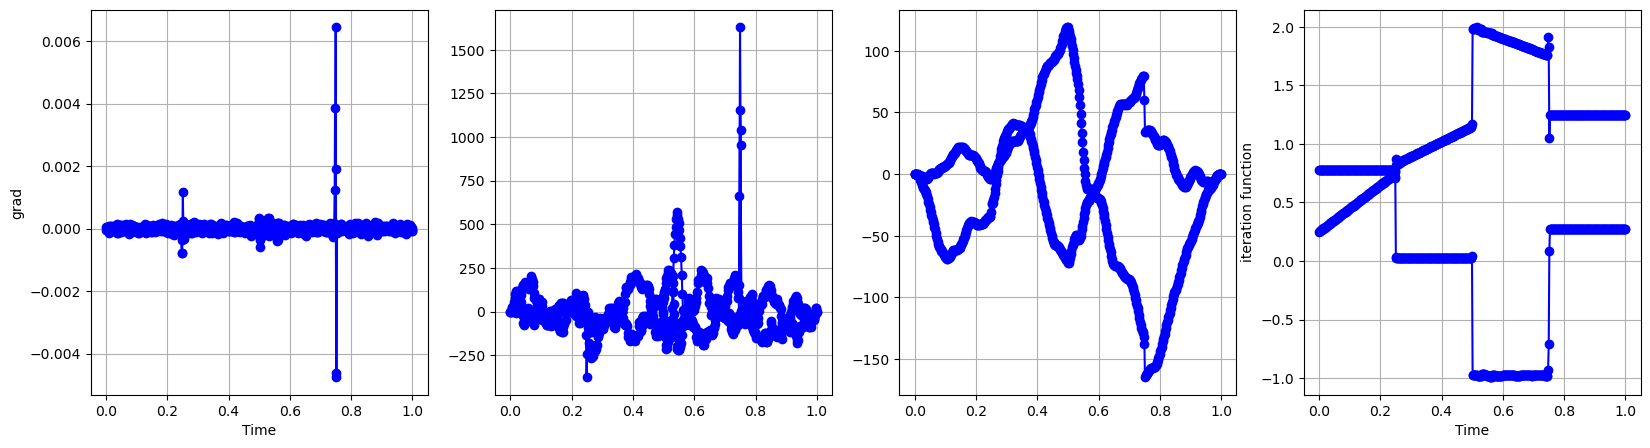

|p_max|/alpha:  602.088905107753 , |P_max|/beta:  168.1294535690276
x_S:  0.542 x_K:  0.75 
New point: sigma= [-0.32491239  0.94574412] x_0 = 0.542 , type = 0
weights:  [0.93637271 1.29512528 0.23225606 1.98388699 0.01078385 0.96903573
 0.70133782 1.11089    0.27663716 0.01984965 0.74294024 0.05725567
 0.16624348 0.01058747 0.02131515 0.08925426 0.01122393 0.02181187
 0.02810217 0.03298729 0.00873425 0.01794005] slope:  [1.28815888 0.0043306 ] y_shift [0.4398356  0.77466742]
Objective:  0.0008181141513623432
22 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9363727116306312 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2951252805362308 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2322560597647781 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9838869877784524 	id: 140075357459264
	 4 sigma= [ 0

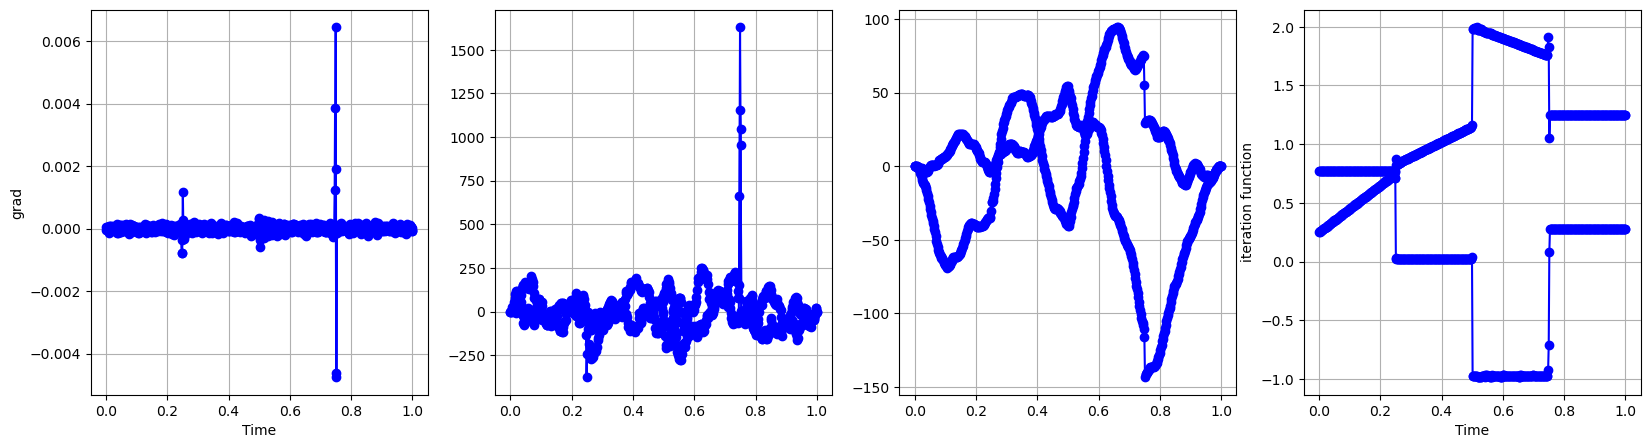

|p_max|/alpha:  289.13494968017056 , |P_max|/beta:  146.44770680784697
x_S:  0.264 x_K:  0.75 
New point: sigma= [-0.93365224 -0.35818081] x_0 = 0.264 , type = 0
weights:  [0.93731312 1.29496463 0.23225626 1.99300598 0.01078886 0.96907369
 0.69318703 1.11089011 0.27663738 0.01986708 0.74188675 0.05021612
 0.1662463  0.01058805 0.02132383 0.0919498  0.01122315 0.02103854
 0.0282532  0.03307019 0.00873342 0.01794497 0.00854198] slope:  [1.29656554 0.00803293] y_shift [0.43767351 0.77373609]
Objective:  0.0008181051804430072
23 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9373131167023536 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2949646289126104 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2322562574062236 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9930059844021522 	id: 140075357459264


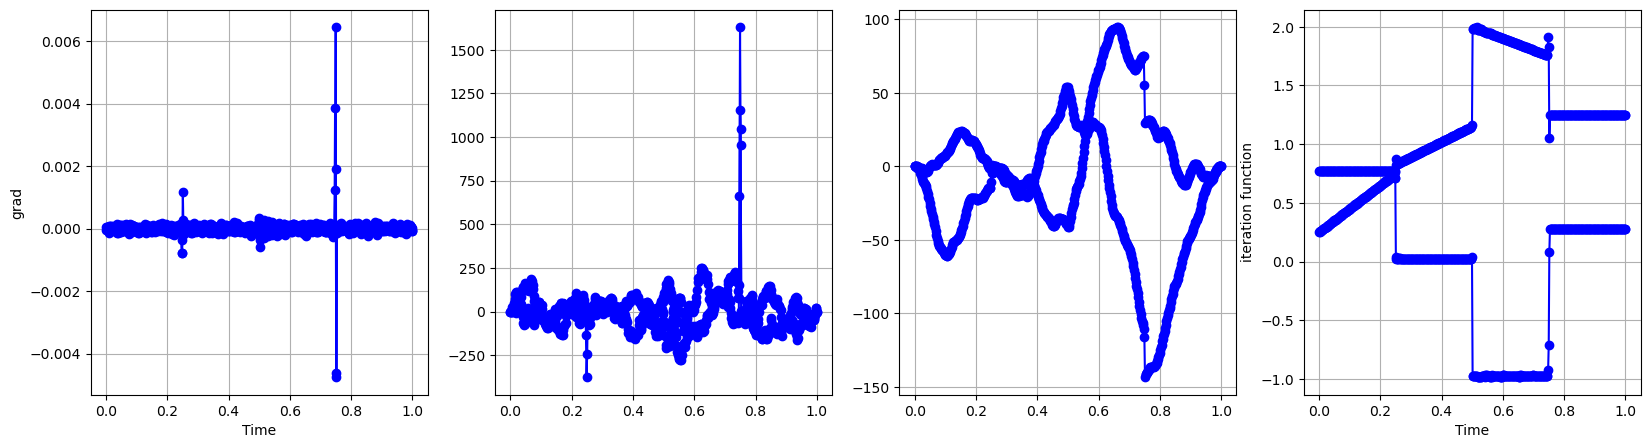

|p_max|/alpha:  286.0602853407101 , |P_max|/beta:  146.38514515443606
x_S:  0.554 x_K:  0.75 
New point: sigma= [-0.96507707  0.26196613] x_0 = 0.554 , type = 0
weights:  [0.93370405 1.29450966 0.23219302 1.97945704 0.01078883 0.95470491
 0.69299818 1.11086834 0.27656885 0.01678545 0.74185424 0.05022212
 0.16523311 0.01037835 0.01991345 0.09171904 0.0118695  0.02119228
 0.02654456 0.03306998 0.0090289  0.0177648  0.0085549  0.00639075] slope:  [1.29678272 0.00782591] y_shift [0.43761569 0.77378744]
Objective:  0.000818099110577748
24 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.933704050002709 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2945096616145704 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23219302230886038 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9794570431620524 	id: 1400753

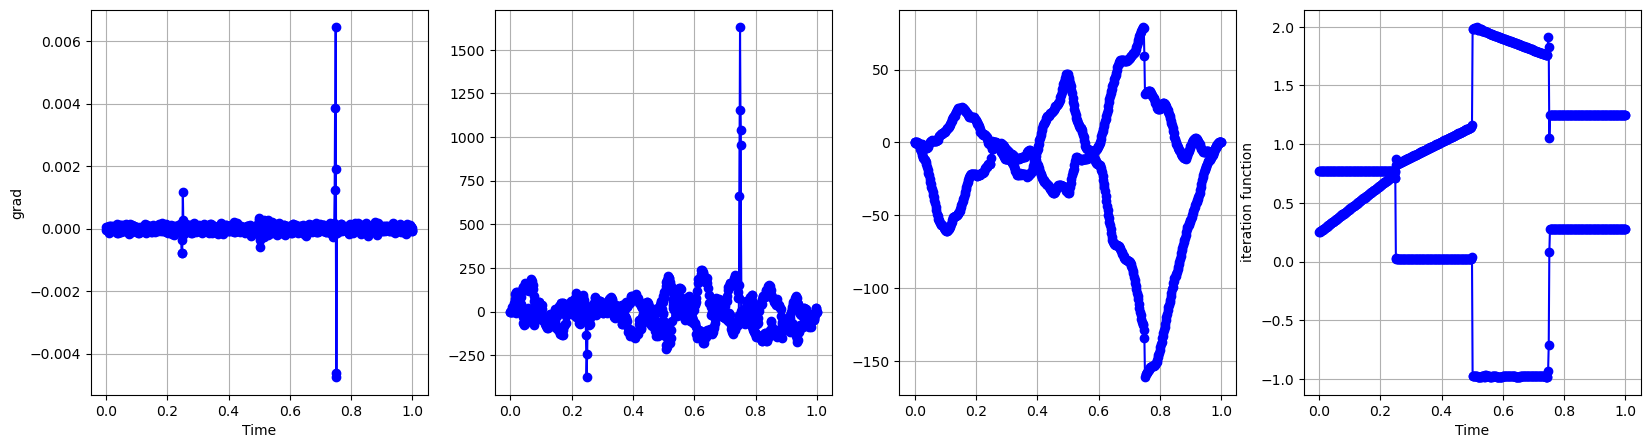

|p_max|/alpha:  284.5587947239748 , |P_max|/beta:  164.4283485197908
x_S:  0.628 x_K:  0.75 
New point: sigma= [-0.62649966  0.7794217 ] x_0 = 0.628 , type = 0
weights:  [0.92567615 1.29455645 0.23223789 1.96120617 0.01078882 0.93438686
 0.69299784 1.11111569 0.27665916 0.01658858 0.74185128 0.05022266
 0.1643151  0.00770549 0.02002917 0.09169422 0.00955264 0.02117498
 0.02676301 0.03306997 0.00931783 0.0174316  0.00855412 0.00693116
 0.00567767] slope:  [1.29678627 0.00780133] y_shift [0.43761479 0.77379358]
Objective:  0.0008180934505892758
25 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9256761520133195 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.2945564530461195 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.23223789218543006 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9612061692155132

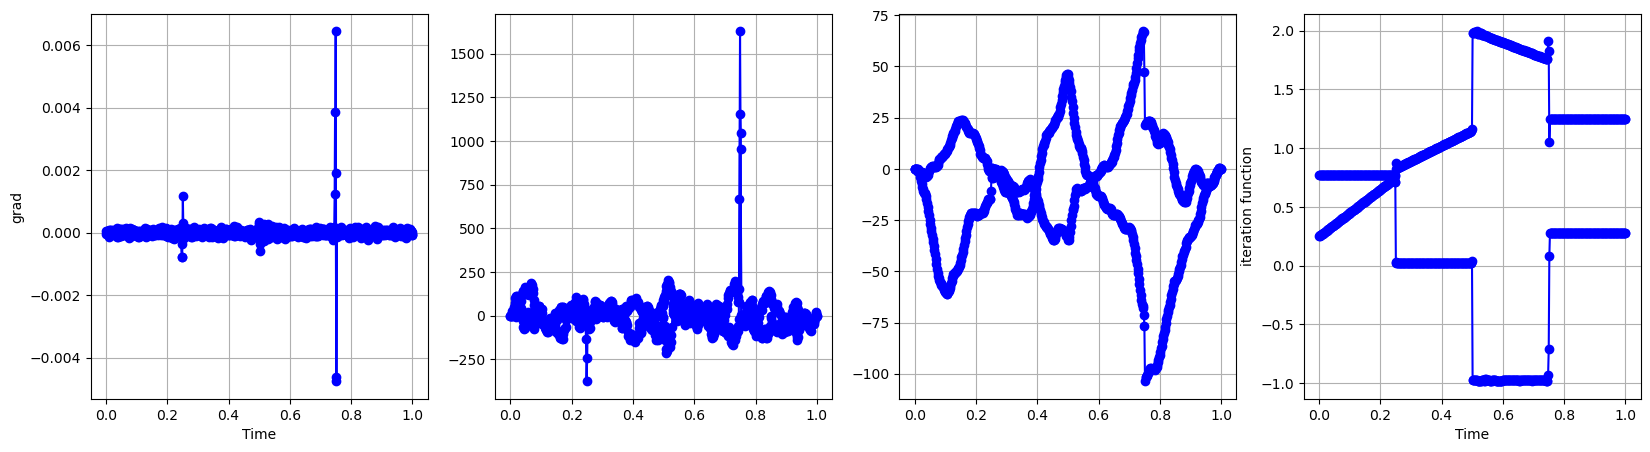

|p_max|/alpha:  271.0045085083021 , |P_max|/beta:  105.80117860609822
x_S:  0.51 x_K:  0.75 
New point: sigma= [-0.75346919  0.65748322] x_0 = 0.51 , type = 0
weights:  [0.92687975 1.30330306 0.23224319 1.96207424 0.0107887  0.93541264
 0.69269378 1.11111827 0.27666476 0.01642701 0.74173859 0.05024331
 0.16439177 0.0077524  0.01682345 0.09081454 0.00958071 0.02090945
 0.02323801 0.03306928 0.00929503 0.01668341 0.00855826 0.00755015
 0.0056064  0.01410659] slope:  [1.29720179 0.00696416] y_shift [0.43750501 0.77400218]
Objective:  0.0008180793102679988
26 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9268797517581571 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.303303059283946 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2322431938930127 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.96207423

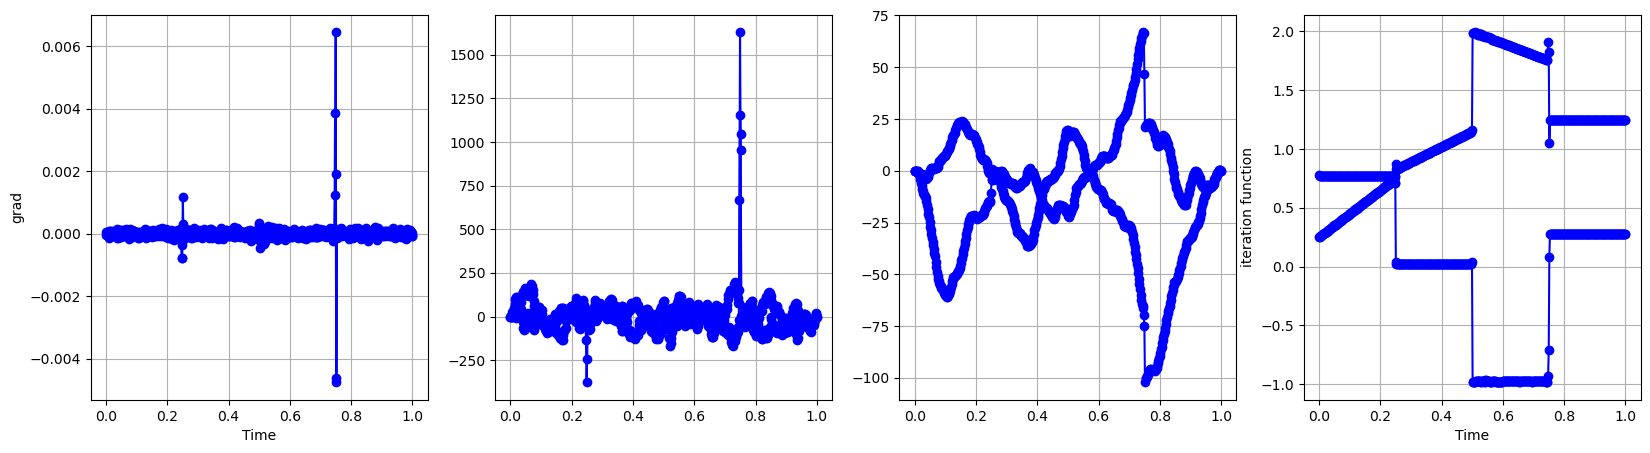

|p_max|/alpha:  241.96661130387764 , |P_max|/beta:  104.19968149974245
x_S:  0.73 x_K:  0.75 
New point: sigma= [-0.56842995  0.82273167] x_0 = 0.73 , type = 0
weights:  [0.92436526 1.30330323 0.22856321 1.95897067 0.0107887  0.93152173
 0.692693   1.11134076 0.27670252 0.01644753 0.74173775 0.05024347
 0.1653747  0.00770989 0.01685584 0.09080765 0.00947423 0.02090593
 0.02329037 0.03306927 0.00731012 0.01655811 0.00855812 0.00780024
 0.00587655 0.01409053 0.00599906] slope:  [1.29720346 0.00695742] y_shift [0.43750457 0.77400386]
Objective:  0.0008180741202439427
27 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9243652631147632 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3033032286753268 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.22856320697723229 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weig

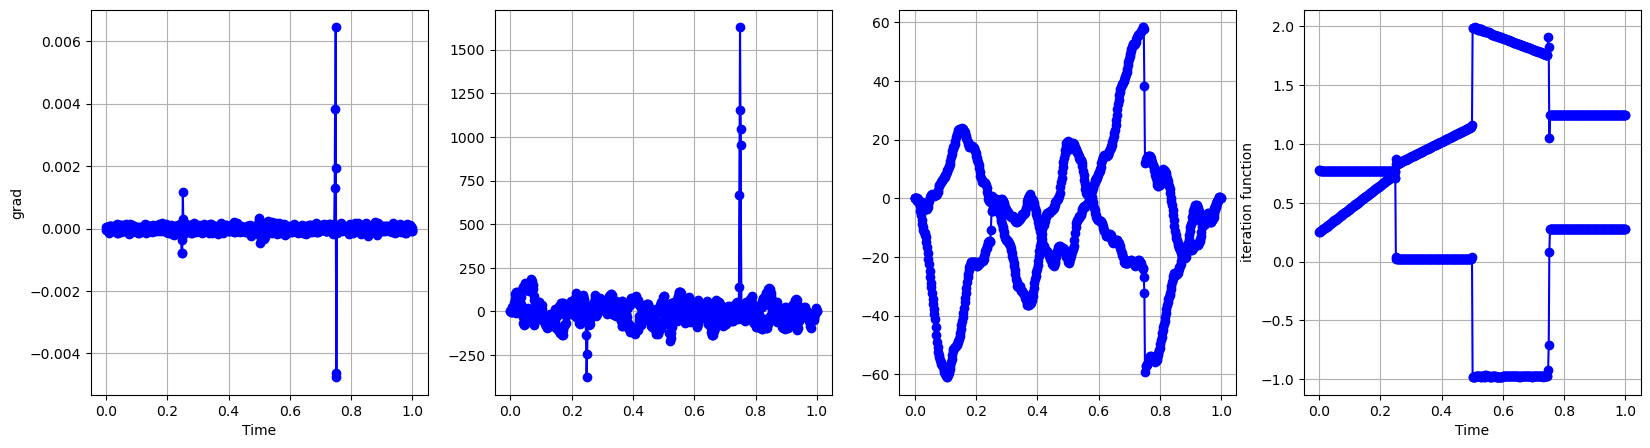

|p_max|/alpha:  188.5401184770711 , |P_max|/beta:  63.743978303478364
x_S:  0.068 x_K:  0.746 
New point: sigma= [ 0.99998015 -0.00630076] x_0 = 0.068 , type = 0
weights:  [0.92441469 1.30329899 0.2285632  1.95897042 0.01084784 0.93152136
 0.67927569 1.11134076 0.27670252 0.01644823 0.74178273 0.05011416
 0.16537467 0.00770988 0.01685662 0.0891315  0.00947426 0.02090653
 0.0232902  0.03213255 0.00731013 0.01655895 0.00842915 0.00780052
 0.00587657 0.01409128 0.00599906 0.00277086] slope:  [1.29723053 0.00691594] y_shift [0.43352651 0.77400701]
Objective:  0.0008180722572243977
28 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9244146852228786 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3032989925487373 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.2285632015972287 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	ty

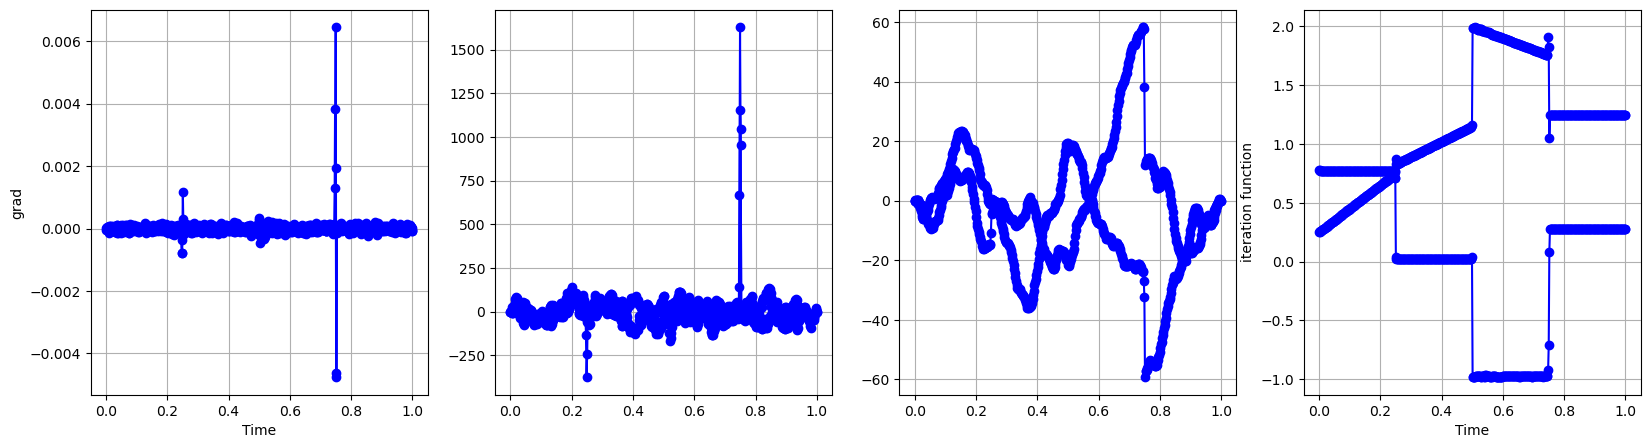

|p_max|/alpha:  169.99043660856844 , |P_max|/beta:  63.744294358377516
x_S:  0.52 x_K:  0.746 
New point: sigma= [-0.9831073   0.18303016] x_0 = 0.52 , type = 0
weights:  [0.92442526 1.30340822 0.2285475  1.95810655 0.01084782 0.93054538
 0.67909876 1.11133884 0.27669728 0.01660208 0.74175247 0.05011973
 0.16530509 0.00766483 0.01187925 0.08891469 0.00944572 0.02033924
 0.01419351 0.03213225 0.00732593 0.01721521 0.00844101 0.00728276
 0.00594605 0.01177117 0.00601642 0.00277117 0.01423804] slope:  [1.29743253 0.00672139] y_shift [0.43347228 0.77405527]
Objective:  0.000818063950180413
29 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.924425264729109 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3034082222668448 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.22854749552041265 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0

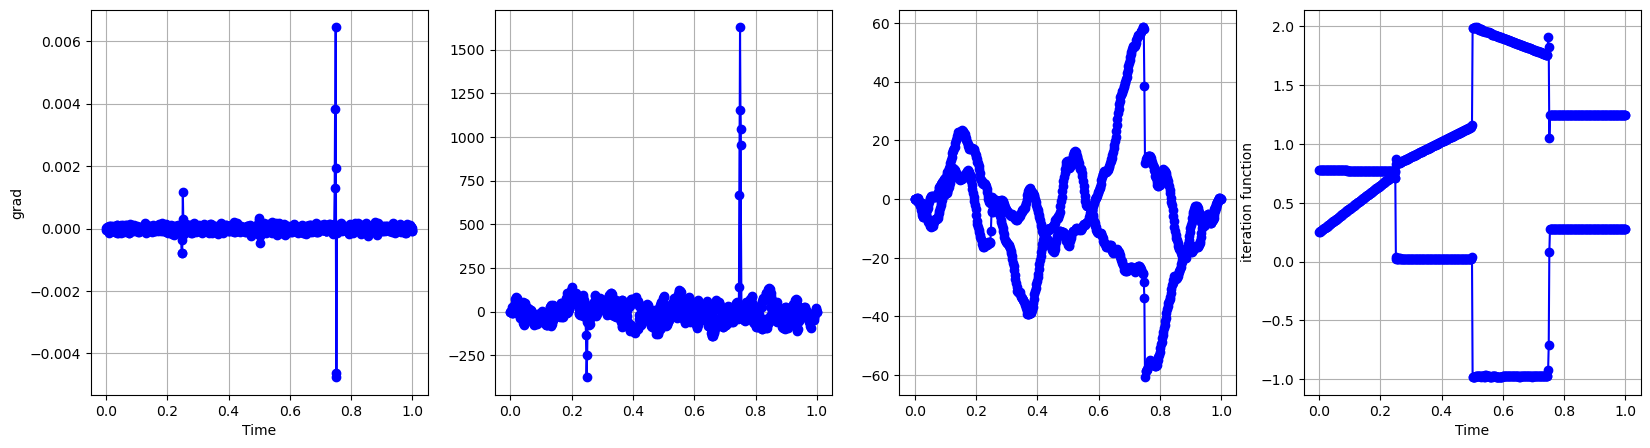

|p_max|/alpha:  147.6123352649468 , |P_max|/beta:  64.5994936808226
x_S:  0.2 x_K:  0.746 
New point: sigma= [0.93236142 0.36152756] x_0 = 0.2 , type = 0
weights:  [0.92448316 1.30340326 0.22854749 1.95810623 0.01113986 0.93054493
 0.6633827  1.11133884 0.27669728 0.01660291 0.74179898 0.04996952
 0.16530506 0.00766482 0.01188002 0.09072296 0.00944576 0.02033992
 0.01419305 0.0326202  0.00732594 0.01721622 0.00828994 0.00728307
 0.00594607 0.01177197 0.00601643 0.00400549 0.01423847 0.00270581] slope:  [1.29746424 0.0066728 ] y_shift [0.4298671  0.77338971]
Objective:  0.0008180624417120778


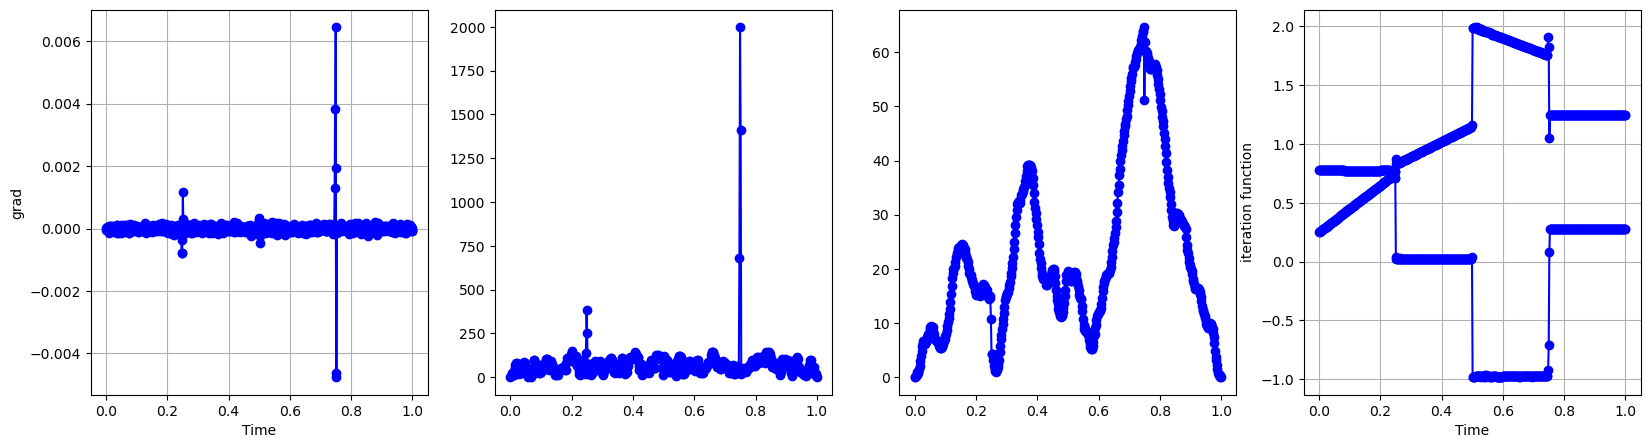

29 : Active set:
	 0 sigma= [-0.54486814  0.83852174] ,	x_0 = 0.5700000000000001 ,	type = 1 	weight: 0.9244831563606601 	id: 140075355461520
	 1 sigma= [ 0.62528014 -0.78040038] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3034032634603288 	id: 140075355857568
	 2 sigma= [-0.35038734  0.93660488] ,	x_0 = 0.748 ,	type = 0 	weight: 0.22854748874885683 	id: 140075357327856
	 3 sigma= [-0.86973029 -0.49352733] ,	x_0 = 0.524 ,	type = 1 	weight: 1.9581062282451764 	id: 140075357459264
	 4 sigma= [ 0.08150585 -0.99667286] ,	x_0 = 0.248 ,	type = 0 	weight: 0.011139858484112952 	id: 140075355847184
	 5 sigma= [0.97958778 0.20101689] ,	x_0 = 0.752 ,	type = 1 	weight: 0.930544925266217 	id: 140075323418976
	 6 sigma= [-0.99329466 -0.11561019] ,	x_0 = 0.268 ,	type = 1 	weight: 0.6633827016266495 	id: 140075327336624
	 7 sigma= [-0.69891545  0.71520431] ,	x_0 = 0.75 ,	type = 0 	weight: 1.1113388354256397 	id: 140075326906032
	 8 sigma= [0.72312924 0.69071275] ,	x_0 = 0.752 ,	type = 0 	weight: 0.27669727851553

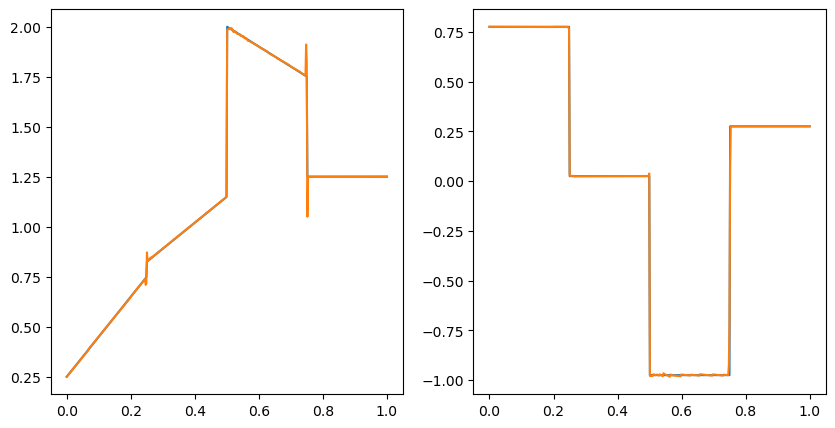

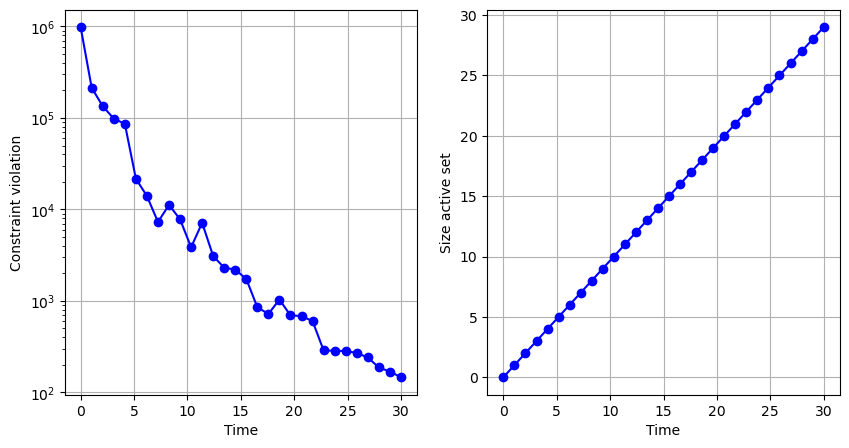

In [5]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)    
    active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet = algorithm(active_set, weights, slope, y_shift, params)
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    fig, (ax3, ax4) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    plot_array(constraintViolation, T=len(constraintViolation), label='Constraint violation', ax=ax3)
    ax3.set_yscale('log')
    plot_array(sizeActiveSet, T=len(sizeActiveSet), label='Size active set', ax=ax4)
    mpl.pyplot.show()

params.maxIterations = 30
params.newton_c = 1
params.maxNewtonSteps = 100
params.pruneThreshold = 0
params.verbose = True
params.mollify_const = 0.01
params.solver = computeSSNStepWalter

s1 = lambda t: (2*t+0.25 if t < 0.25 else(1.3*t + 0.5 if t < 0.5 else (-t+2.5 if t < 0.75 else 1.25)))
#s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
#s1 = lambda t : (0.05*t if t <= 0.25 else (0.90*t + 1 if t <= 0.5 else -2 - 0.95*t if t <= 0.75 else 0.3)) #/ params.alpha
s2 = lambda t : (0.775 if t <= 0.25 else (0.025 if t <= 0.5 else (-0.975 if t <= 0.75 else 0.275)))
setupObservation(s1, s2, params)

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
#gradient_test = buildControlFunctionAdjoint([g1, g2], solveAdjointEquation(params.yd, params), params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)

testRegularizationParameters(7e-9, 1e-9, params, array)
#testRegularizationParameters(1e-8, 1e-6, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)